# Setup

Ensure all dependencies are installed.


In [ ]:
%pip install -U -r requirements.txt

  Cloning ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git (to revision main) to /tmp/pip-install-hqxg6667/m2p_d851e24dc487432cabd9c86da5523f23
  Running command git clone --filter=blob:none --quiet 'ssh://****@gitlab.utwente.nl/s2219735-bsc-research-project/mesh-to-points.git' /tmp/pip-install-hqxg6667/m2p_d851e24dc487432cabd9c86da5523f23


Check if we have GPU support, and if not, warn the user.


In [2]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [2]:
import os
from data_sources.modelnet40 import ModelNet40
from models.dataset import PointCloudDataset
from typing import List

train_folder = "data/train"
test_folder = "data/test"

train_dataset: PointCloudDataset = None
test_dataset: PointCloudDataset = None

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print("Train and test data found. Reading data...")
    train_files: List[str] = []
    test_files: List[str] = []

    for root, dirs, files in os.walk(train_folder):
        for file in files:
            train_files.append(os.path.join(root, file))

    for root, dirs, files in os.walk(test_folder):
        for file in files:
            test_files.append(os.path.join(root, file))

    train_dataset = PointCloudDataset(train_files)
    test_dataset = PointCloudDataset(test_files)
    k = 40
else:
    classes, train_dataset, test_dataset = ModelNet40.download(
        npoints=2500, train_outdir=train_folder, test_outdir=test_folder
    )
    k = len(classes)

print(f"Training data: {len(train_dataset)} samples")
print(f"Test data size: {len(test_dataset)} samples")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Train and test data found. Reading data...
Training data: 9843 samples
Test data size: 2468 samples


# Training

Train a new classifier or load a new pre-trained one:


In [5]:
from pointnet.train_classification import train_classification
from pointnet.model import PointNetCls

classifier_path = "pointnet/classifier.pth"  # pointnet/classifier.pth

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=k)
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")
else:
    classifier = train_classification(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        k=k,
        epochs=25,
        outf="./pointnet/cls",
    )

Loading existing model from pointnet/classifier.pth...
Classifier loaded successfully.


Run a simple classification to get a visualization of our classifier.


Scores: [-9.709823608398438, -12.030512809753418, -18.429460525512695, -14.573141098022461, -22.376035690307617, -14.533973693847656, -20.455812454223633, -18.392854690551758, -17.596773147583008, -18.774808883666992, -20.065078735351562, -16.702625274658203, -20.79045867919922, -12.927494049072266, -15.436097145080566, -11.397209167480469, -17.333032608032227, -12.237313270568848, -15.051385879516602, -7.662439823150635, -13.51956558227539, -12.212697982788086, -12.946447372436523, -24.593799591064453, -19.4309024810791, -12.441404342651367, -24.365550994873047, -19.02574348449707, -12.118308067321777, -13.79297924041748, -19.38942527770996, -14.003040313720703, -20.63419532775879, -19.801843643188477, -0.0005781171494163573, -14.859358787536621, -22.366506576538086, -15.241865158081055, -16.54352378845215, -14.714954376220703]
Expected class: 34
Predicted class: 34


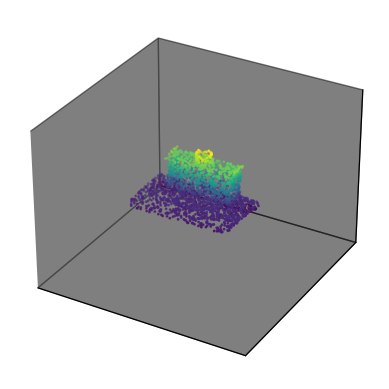

In [20]:
import random
import torch
from utils.plot import plot_points

i = random.randint(0, len(test_dataset) - 1)

input_data = test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
print("Scores:", scores.tolist())
print(f"Expected class: {int(test_dataset[i][1])}")
print(f"Predicted class: {scores.argmax().item()}")

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Train the segmenter:


In [ ]:
from pointnet.train_segmentation import train_segmentation

train_segmentation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    epochs=25,
    class_choice=0,
    outf="./pointnet/seg",
)